**Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

**Code**

In [2]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True  # Enables bidirectional functionality
        )
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply hidden_size by 2 for BiLSTM

    def forward(self, x):
        # LSTM outputs
        out, _ = self.lstm(x)  # out -> (batch_size, seq_length, hidden_size * 2)
        # Get output from the last time step
        out = self.fc(out[:, -1, :])  # out -> (batch_size, output_size)
        return out

In [4]:
# Hyperparameters
input_size = 28          # Number of features (e.g., pixels per row in an image)
hidden_size = 128        # Number of LSTM hidden units
output_size = 10         # Number of output classes
num_layers = 2           # Number of LSTM layers
dropout = 0.3            # Dropout rate
learning_rate = 0.001
sequence_length = 28     # Sequence length (e.g., rows of pixels in an image)
batch_size = 64          # Batch size
num_epochs = 10          # Number of epochs

In [5]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, Optimizer
model = BiLSTMModel(input_size, hidden_size, output_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Training Loop
for epoch in range(num_epochs):
    correct = 0
    total = 0
    epoch_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, sequence_length, input_size).to(device)  # Reshape images for LSTM
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Calculate predictions and accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch [1/10], Loss: 0.4080, Accuracy: 86.57%
Epoch [2/10], Loss: 0.1103, Accuracy: 96.72%
Epoch [3/10], Loss: 0.0753, Accuracy: 97.74%
Epoch [4/10], Loss: 0.0592, Accuracy: 98.21%
Epoch [5/10], Loss: 0.0484, Accuracy: 98.51%
Epoch [6/10], Loss: 0.0414, Accuracy: 98.72%
Epoch [7/10], Loss: 0.0379, Accuracy: 98.87%
Epoch [8/10], Loss: 0.0338, Accuracy: 98.97%
Epoch [9/10], Loss: 0.0282, Accuracy: 99.13%
Epoch [10/10], Loss: 0.0266, Accuracy: 99.19%


In [7]:
# Testing function
def test_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_labels = []       # To store all true labels
    all_predictions = []  # To store all predictions

    with torch.no_grad():  # Disable gradient calculations for testing
        for images, labels in test_loader:
            images = images.view(-1, sequence_length, input_size).to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predictions

            # Collect all labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Compute accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_labels, all_predictions

# Call test function and get all labels and predictions
all_labels, all_predictions = test_model(model, test_loader, device)

# Print sample labels and predictions
print("Sample True Labels:", all_labels[:10])
print("Sample Predictions:", all_predictions[:10])

Test Accuracy: 98.92%
Sample True Labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Sample Predictions: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


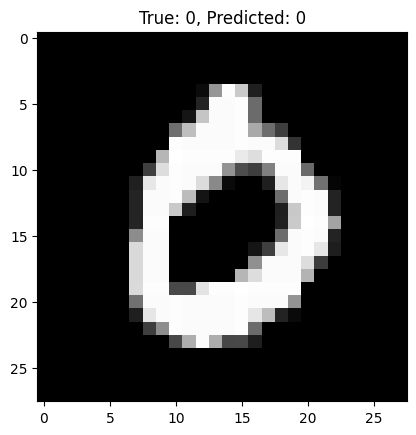

In [8]:
# Visualizing a Sample
import matplotlib.pyplot as plt

sample_image, sample_label = test_dataset[3]  # Pick a sample from the test dataset
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension

output = model(sample_image.view(-1, sequence_length, input_size))
_, predicted = torch.max(output, 1)

plt.imshow(sample_image.cpu().squeeze(), cmap='gray')
plt.title(f"True: {sample_label}, Predicted: {predicted.item()}")
plt.show()